In [1]:
import torch
import torchvision.datasets as dsets

import numpy as np
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader


import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

    
from lazyvi import LazyVI
from data_generating_funcs import *
from networks import *

from matplotlib import pyplot as plt
import seaborn as sns
import copy, time


In [73]:
# Feature groups
width = 4
num_superpixels = 28 // width
groups = []
for i in range(num_superpixels):
    for j in range(num_superpixels):
        img = np.zeros((28, 28), dtype=int)
        img[width*i:width*(i+1), width*j:width*(j+1)] = 1
        img = img.reshape((784,))
        groups.append(np.where(img)[0])
        
def loader_accuracy(dl, model):
    correct = 0
    total = 0
    for x, y in dl:
        correct+=(sum(model(x).argmax(1) == y))
        total+=len(y)
    return correct/total

def modify_loader(img_dataset, grp, fill_val=0):
    modimg = img_dataset.data.reshape(-1, 28*28)
    #modimg[:, grp] = img_dataset.data.detach().numpy().mean()
    modimg[:, grp] = fill_val
    img_dataset.data = modimg.reshape(-1,28,28)
    return DataLoader(img_dataset, batch_size=64, num_workers=2)

In [3]:
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])


train_dataset = MNIST('data', train=True, download=True, transform=transform)
test_dataset = MNIST('data', train=False, download=True, transform=transform)

#test_mod = test_dataset.data

#Create train loader
train_dl = DataLoader(train_dataset, batch_size=64, num_workers=2)
#Create validation loader
test_dl = DataLoader(test_dataset, batch_size=128, num_workers=2)

# Train model

In [ ]:
results = []
dr_img = np.zeros(28*28)
rt_img = np.zeros(28*28)
lz_img = np.zeros(28*28)



#for i, grp in enumerate(groups):
for j in range(5,6):
    print(f'=======iter{j}=======')
    train_dataset = MNIST('data', train=True, download=True, transform=transform)
    test_dataset = MNIST('data', train=False, download=True, transform=transform)

    #test_mod = test_dataset.data

    #Create train loader
    train_dl = DataLoader(train_dataset, batch_size=64, num_workers=2)
    #Create validation loader
    test_dl = DataLoader(test_dataset, batch_size=128, num_workers=2)

    # most basic trainer, uses good defaults (1 gpu)
    # It also prints the model summary comparable to keras summary for free.
    model = MNIST10_cnn()

    # Here you can add many features in your Trainer: such as num_epochs,  gpus used, clusters used etc.
    trainer = pl.Trainer(max_epochs=5)

    trainer.fit(model, train_dl)
    
    full_mse = loader_accuracy(test_dl, model).item()

    results.append([0, 'dropout', 0, full_mse])
    results.append([0, 'retrain', 0, full_mse])
    results.append([0, 'lazy', 0, full_mse])
    full_params = model.state_dict()
    
    for t in [.1, .25, .5, .75, .9, .99]:  
    #for t in [.99]:
        print(t)
        trn = copy.deepcopy(train_dataset)
        tst = copy.deepcopy(test_dataset)
        ix = np.random.choice(len(groups), int(len(groups)*t), replace=False)
        for i in ix:
            grp = groups[i]
            train_j = modify_loader(trn, grp)
            test_j = modify_loader(tst, grp)

        # dropout
        t0 = time.time()
        acc_j = loader_accuracy(test_j, model).item()
        results.append([t, 'dropout', time.time() - t0, acc_j])
        dr_img[grp] = acc_j

        # retrain
        t0 = time.time()
        modelj_rt = MNIST10_cnn()
        trainer = pl.Trainer(max_epochs=5)
        trainer.fit(modelj_rt, train_j)
        acc_j = loader_accuracy(test_j, modelj_rt).item()
        results.append([t, 'retrain', time.time() - t0, acc_j])
        rt_img[grp] = acc_j

        # early stop
        t0 = time.time()
        modelj = MNIST10_cnn()
        modelj.load_state_dict(full_params)
        trainer = pl.Trainer(max_epochs=1)
        trainer.fit(modelj, train_j)
        acc_j = loader_accuracy(test_j, modelj).item()
        results.append([t, 'lazy', time.time() - t0, acc_j])
        lz_img[grp] = acc_j
    
    tmp = pd.DataFrame(results, columns=['pct_removed', 'method', 'time', 'acc'])
    tmp.to_csv(f'mnist_earlystop_iter{j}_avi_norepl.csv', index=False)

In [25]:
df = pd.DataFrame()
for i in range(5):
    tmp = pd.read_csv(f'mnist_earlystop_iter{i}_avi_norepl.csv')
    df = df.append(tmp, ignore_index=True)
    
#df = pd.DataFrame(results, columns=['pct_missing', 'method', 'time', 'acc'])
method_map = {
    'dropout':'Dropout',
    'lazy':'LazyVI-ES',
    'retrain':'Retrain'
}

df['method'] = df.method.map(method_map)

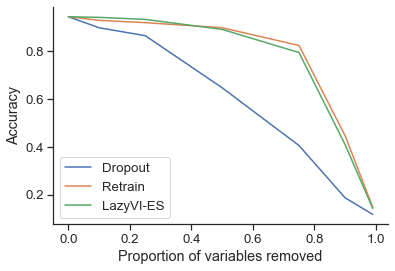

In [28]:
g = sns.lineplot(x='pct_removed', y='acc', hue='method', data=df, ci=None)
sns.despine()
plt.ylabel('Accuracy')
plt.xlabel('Proportion of variables removed')
g.legend_.set_title(None)

In [ ]:
for x, y in train_data

In [63]:
mnisty = {}
for x,y in train_dl:
    mnisty[0] = x[0,0]
    break
for t in [.1, .25, .5, .75, .9, .99]:  
    print(t)
    trn = copy.deepcopy(train_dataset)
    ix = np.random.choice(len(groups), int(len(groups)*t), replace=False)
    for i in ix:
        grp = groups[i]
        train_j = modify_loader(trn, grp)
    for x, y in train_j:
        mnisty[t] = x[0,0]
        #plt.imshow(x[0,0], cmap='Blues')
        #plt.title(t)
        #plt.show()
        break

0.1
0.25
0.5
0.75
0.9
0.99


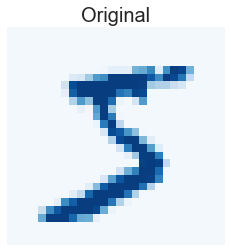

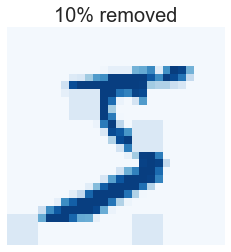

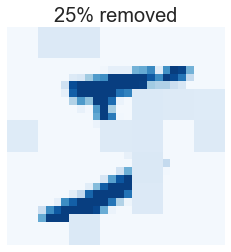

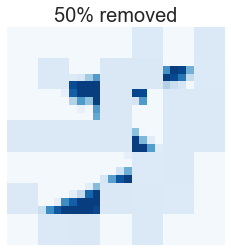

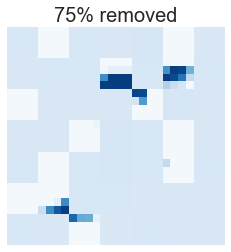

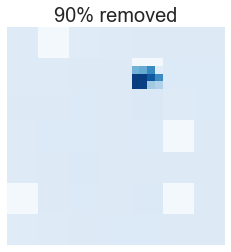

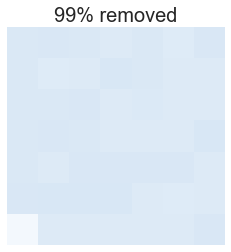

In [88]:
for t in mnisty:
    plt.imshow(mnisty[t], cmap='Blues', vmin=-.5, vmax=3)
    if t == 0:
        plt.title('Original', fontsize=20)
    else:
        plt.title(f'{int(t*100)}% removed', fontsize=20)
    #plt.xlabel(f"t={t}")
    plt.axis('off')
    plt.show()
    

Text(0.5, 0, '')

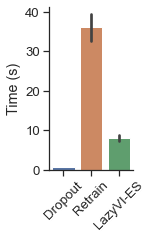

In [33]:
plt.figure(figsize=(1.5,3))
sns.barplot(x='method', y='time', data=df)
sns.despine()
plt.xticks(rotation=45)
plt.ylabel('Time (s)')
plt.xlabel('')